# Data Analysis Notebook

## Interpretation

This is my interpretation of what the data represents:

<b>Data series 1</b> is most definitely measuring of the electricity produced by a PV system. The profile has a regular daily pattern which stays at zero during the night and increases during the morning, reaching a peak at midday, before decreasing again towards the evening. This clear daily cycle is also reflected in the strong periodicity seen in the autocorrelation plot. 

The variability of sunlight shining on the panels can be seen across different days or when looking at the sudden drops that can be experienced through changes in cloud coverage. As we are only in February, zero power output is already reached at 17:00. Also due to the time of the year, we can see that there is a trend of increasing PV production in the plot showing the weekly average energy value. Unfortunately, the seasonal decomposition is not able to separate this trend from the remaining factors. 

The unit may be in MW, as the production peak is 0.173250, which would then correspond to 173.25 kW or around 580 panels producing at 300W in January (rated ~350 Wp). The measurement might come from a large building or a small local energy community.

<b>Data series 2</b> may be smart meter measurements of residential consumers without PV production (or deducted). The series shows fluctuating values throughout the day without a clear daily cycle and with frequent peaks and dips. We can observe higher consumption peaks in the evening, which is typical for residential loads. The autocorrelation plot reveals that there is still some weak periodicity albeit with more noise which indicates somehow regular patterns (e.g., behavioral). 

The series also hits the same floor level multiple times a day, which could correspond to the standby consumption of household devices. Given that the weekend consumption is on average not lower than the weekday consumption, we can exclude non-residential customers. 

What I cannot explain, is why the average values are not lower during the night and midday. Maybe I am missing a puzzle piece here and it is not residential load after all? :)


## Imports

In [1]:
import os

import pandas as pd
from pandas import json_normalize
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from ydata_profiling import ProfileReport

In [2]:
print(os.getcwd())

c:\Users\nicco\OneDrive - ETH Zurich\Organisatorisches\Bewerbungen\2024\Exnaton - Spontanbewerbung\Coding Challenge\exnaton_challenge\task_a\notebooks


## Load Data

In [3]:
def read_norm_json(file_path):
    df = pd.read_json(file_path)
    df = pd.json_normalize(df['data'])
    return df

In [4]:
df1 = read_norm_json('../data/1db7649e.json')
df2 = read_norm_json('../data/95ce3367.json')

In [5]:
df1

,measurement,timestamp,0100021D00FF,tags.muid,tags.quality
0,energy,2023-02-28T23:45:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
1,energy,2023-02-28T23:30:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
2,energy,2023-02-28T23:15:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
3,energy,2023-02-28T23:00:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
4,energy,2023-02-28T22:45:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
...,...,...,...,...,...
2683,energy,2023-02-01T01:00:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
2684,energy,2023-02-01T00:45:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
2685,energy,2023-02-01T00:30:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured
2686,energy,2023-02-01T00:15:00.000Z,0.0,1db7649e-9342-4e04-97c7-f0ebb88ed1f8,measured


In [6]:
df2

,measurement,timestamp,0100011D00FF,tags.muid,tags.quality
0,energy,2023-02-28T23:45:00.000Z,0.0117,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
1,energy,2023-02-28T23:30:00.000Z,0.0117,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
2,energy,2023-02-28T23:15:00.000Z,0.0118,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
3,energy,2023-02-28T23:00:00.000Z,0.0118,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
4,energy,2023-02-28T22:45:00.000Z,0.0210,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
...,...,...,...,...,...
2683,energy,2023-02-01T01:00:00.000Z,0.0117,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
2684,energy,2023-02-01T00:45:00.000Z,0.0117,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
2685,energy,2023-02-01T00:30:00.000Z,0.0118,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured
2686,energy,2023-02-01T00:15:00.000Z,0.0117,95ce3367-cbce-4a4d-bbe3-da082831d7bd,measured


## Data Cleaning and Preprocessing

In [7]:
# Check for missing values
print(df1.isnull().sum())
print(df1.isna().sum()) 

measurement     0
timestamp       0
0100021D00FF    0
tags.muid       0
tags.quality    0
dtype: int64
measurement     0
timestamp       0
0100021D00FF    0
tags.muid       0
tags.quality    0
dtype: int64


In [8]:
# Preprocessing
def preprocess_df(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

df1 = preprocess_df(df1)
df2 = preprocess_df(df2)

## Exploratory Data Analysis

In [9]:
print("DataFrame Info:")
print(df1.info())  # Get info on DataFrame structure

print("\nFirst few rows:")
print(df1.head())  # Display the first few rows of the DataFrame

print("\nDescribe Data:")
print(df1.describe())  # Statistical summary of numerical columns

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688 entries, 0 to 2687
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   measurement   2688 non-null   object             
 1   timestamp     2688 non-null   datetime64[ns, UTC]
 2   0100021D00FF  2688 non-null   float64            
 3   tags.muid     2688 non-null   object             
 4   tags.quality  2688 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 105.1+ KB
None

First few rows:
  measurement                 timestamp  0100021D00FF  \
0      energy 2023-02-28 23:45:00+00:00           0.0   
1      energy 2023-02-28 23:30:00+00:00           0.0   
2      energy 2023-02-28 23:15:00+00:00           0.0   
3      energy 2023-02-28 23:00:00+00:00           0.0   
4      energy 2023-02-28 22:45:00+00:00           0.0   

                              tags.muid tags.quali

In [10]:
# profile = ProfileReport(df, title="Pandas Profiling Report 1")
# profile.to_file("Profile1.html")

### Full timeseries

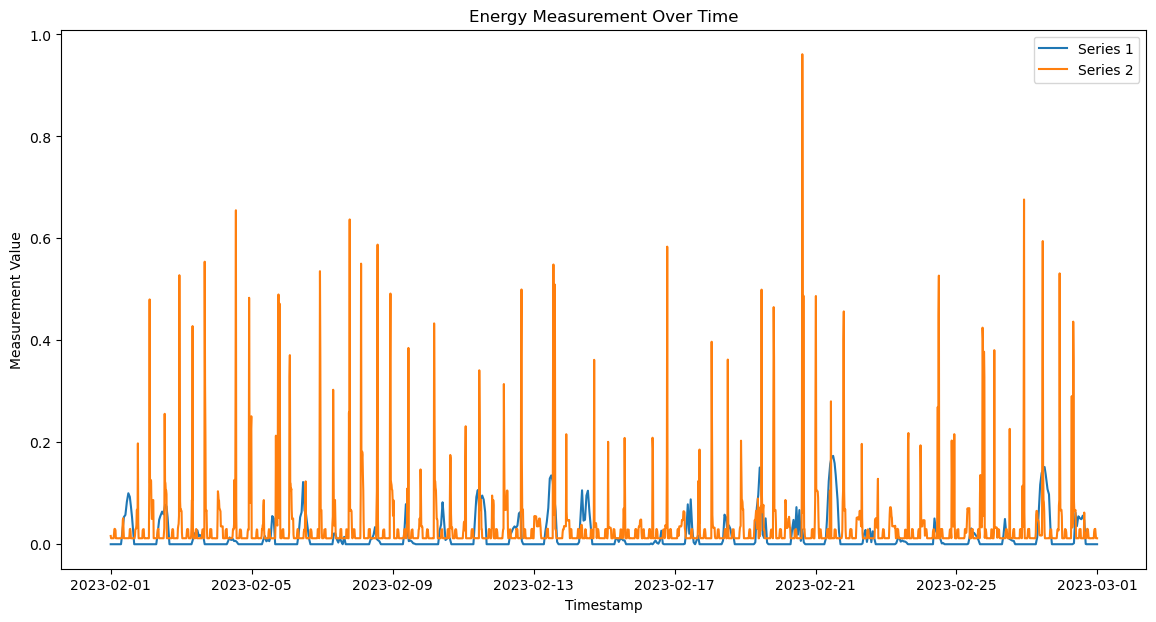

In [11]:
# Plotting energy measurements over time
plt.figure(figsize=(14, 7))
plt.plot(df1['timestamp'], df1['0100021D00FF'], label='Series 1')
plt.plot(df2['timestamp'], df2['0100011D00FF'], label='Series 2')
plt.title('Energy Measurement Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Measurement Value')
plt.legend()
plt.show()

### Average Day

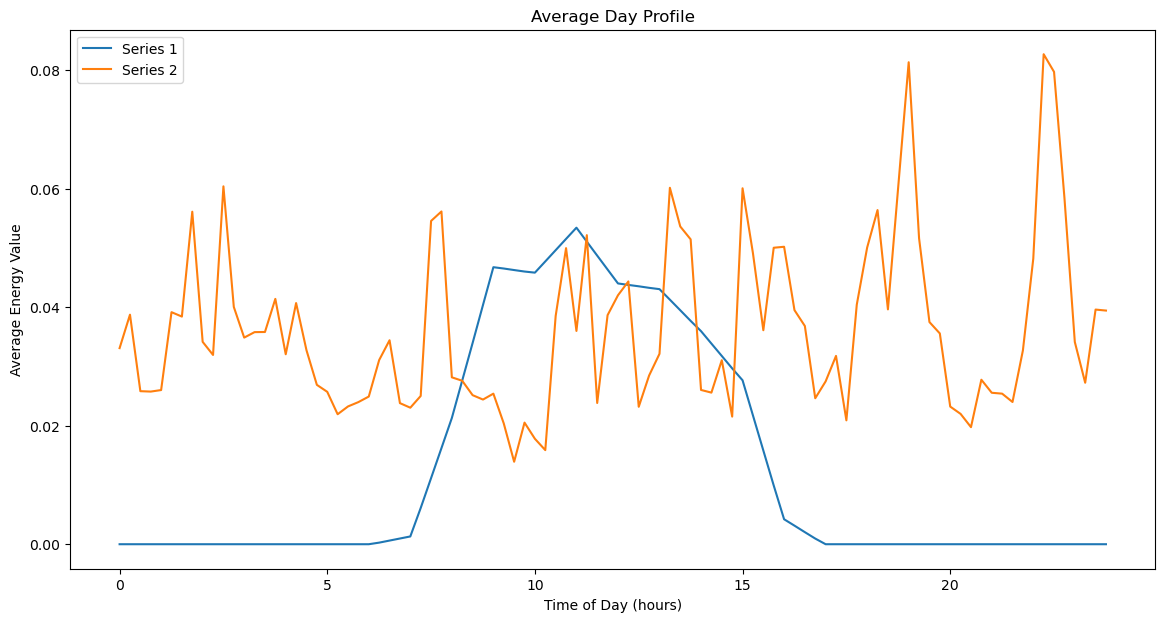

In [12]:
def plot_average_day(df, time_col, value_col, label):
    df['hour'] = df[time_col].dt.hour
    df['minute'] = df[time_col].dt.minute
    avg_day = df.groupby(['hour', 'minute'])[value_col].mean().reset_index()
    avg_day['time'] = avg_day['hour'] + avg_day['minute'] / 60.0
    
    plt.plot(avg_day['time'], avg_day[value_col], label=label)

plt.figure(figsize=(14, 7))
plot_average_day(df1, 'timestamp', '0100021D00FF', 'Series 1')
plot_average_day(df2, 'timestamp', '0100011D00FF', 'Series 2')
plt.title('Average Day Profile')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Average Energy Value')
plt.legend()
plt.show()

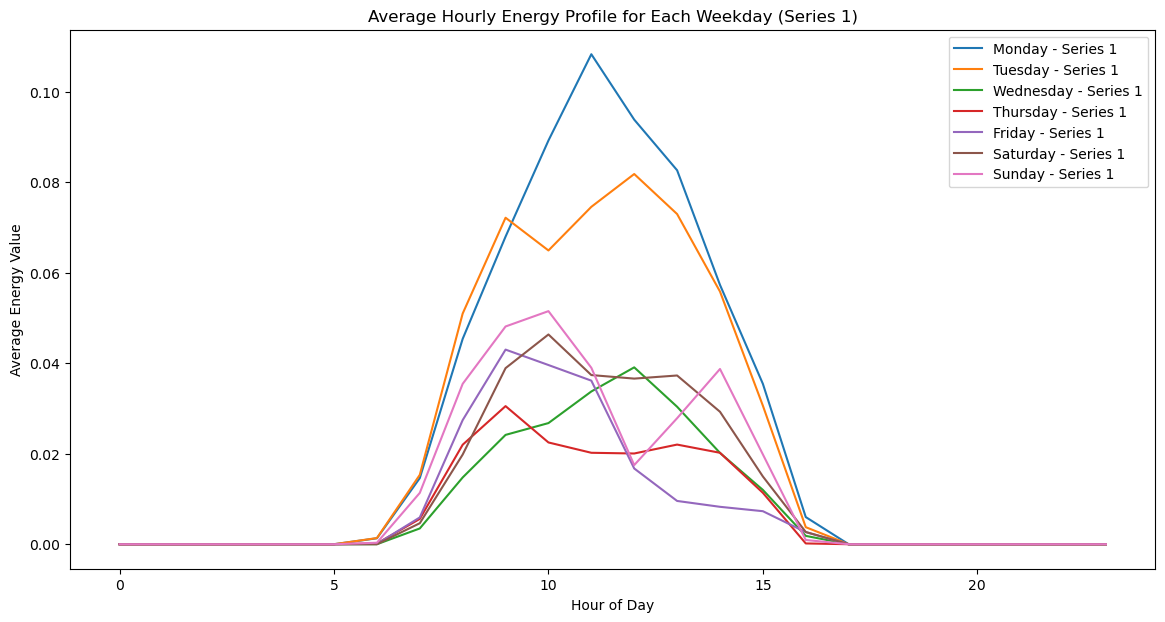

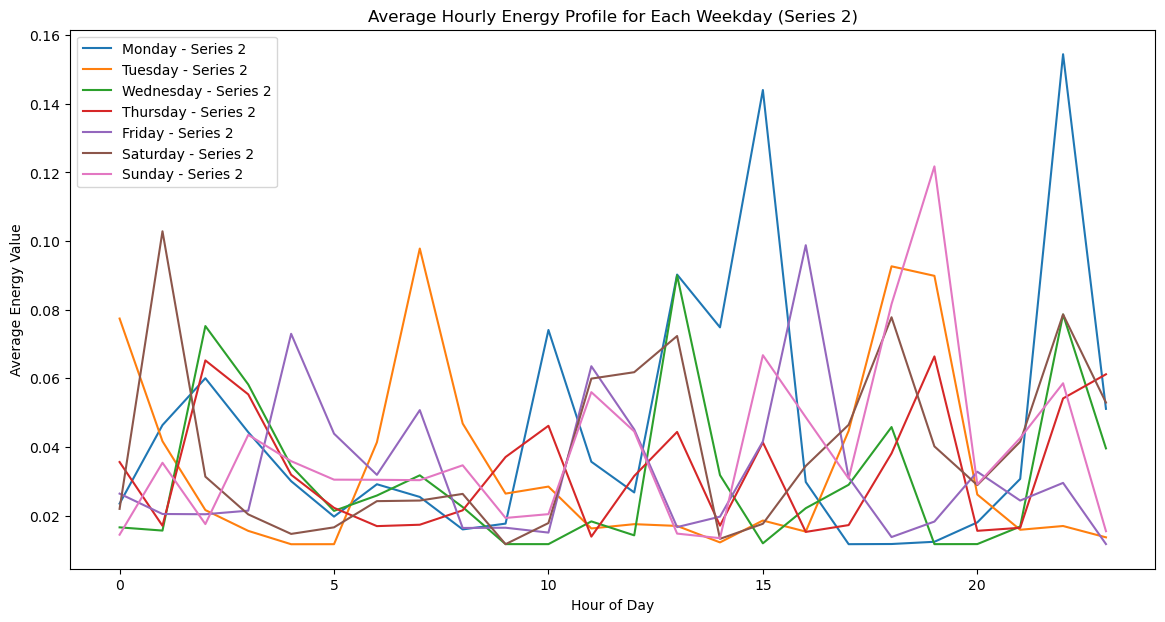

In [13]:
def plot_weekday_profiles(df, time_col, value_col, series_label):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.figure(figsize=(14, 7))
    for day in range(7):
        daily_avg = df[df[time_col].dt.dayofweek == day].groupby(df[time_col].dt.hour)[value_col].mean()
        plt.plot(daily_avg.index, daily_avg.values, label=f'{weekdays[day]} - {series_label}')
    plt.title(f'Average Hourly Energy Profile for Each Weekday ({series_label})')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Energy Value')
    plt.legend()
    plt.show()

plot_weekday_profiles(df1, 'timestamp', '0100021D00FF', 'Series 1')
plot_weekday_profiles(df2, 'timestamp', '0100011D00FF', 'Series 2')

In [14]:
def print_weekday_weekend_avg(df, value_col, label):
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    weekdays = df[df['day_of_week'] < 5]
    weekends = df[df['day_of_week'] >= 5]
    weekday_avg = weekdays[value_col].mean()
    weekend_avg = weekends[value_col].mean()
    print(f'Series {label} - Weekday Average: {weekday_avg}, Weekend Average: {weekend_avg}')

print_weekday_weekend_avg(df1, '0100021D00FF', 1)
print_weekday_weekend_avg(df2, '0100011D00FF', 2)

Series 1 - Weekday Average: 0.014199218750000001, Weekend Average: 0.011633789062499999
Series 2 - Weekday Average: 0.03521145833333334, Weekend Average: 0.03906536458333334


## Average Week

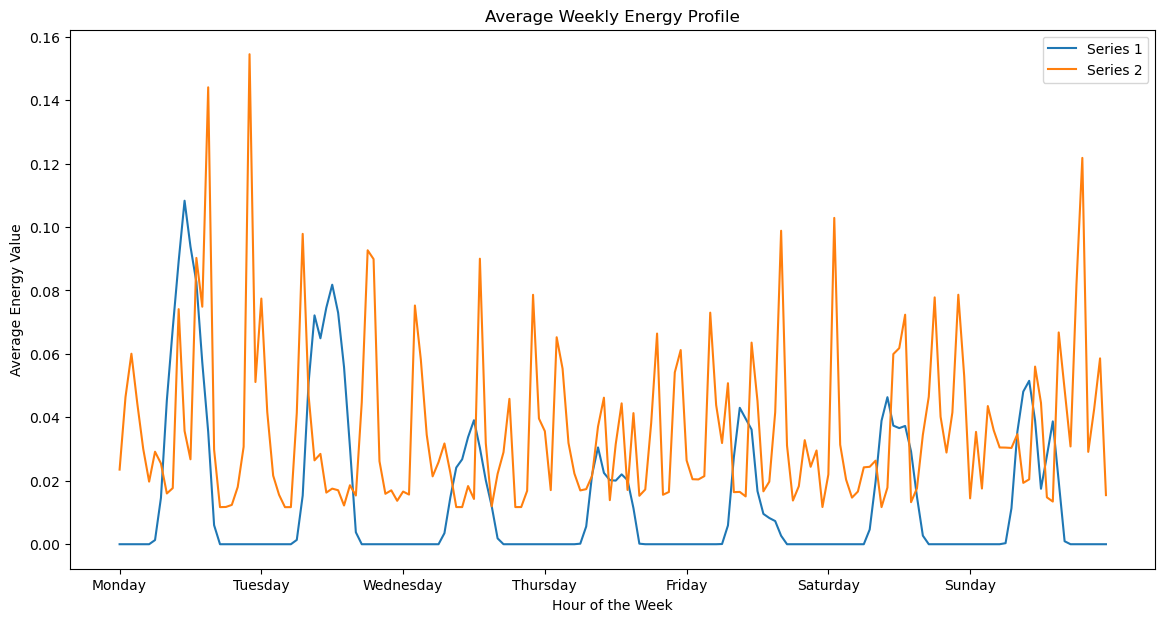

In [15]:
def average_week_aggregation(df, time_col, value_col):
    df['weekday'] = df[time_col].dt.dayofweek
    df['hour'] = df[time_col].dt.hour
    avg_week = df.groupby(['weekday', 'hour'])[value_col].mean().reset_index()
    avg_week['time'] = avg_week['weekday'] * 24 + avg_week['hour']
    return avg_week

def plot_average_week(avg_week1, avg_week2):
    plt.figure(figsize=(14, 7))
    plt.plot(avg_week1['time'], avg_week1['0100021D00FF'], label='Series 1')
    plt.plot(avg_week2['time'], avg_week2['0100011D00FF'], label='Series 2')
    plt.title('Average Weekly Energy Profile')
    plt.xlabel('Hour of the Week')
    plt.ylabel('Average Energy Value')
    plt.xticks(ticks=[i*24 for i in range(7)], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.legend()
    plt.show()

# Perform average week aggregation
avg_week1 = average_week_aggregation(df1, 'timestamp', '0100021D00FF')
avg_week2 = average_week_aggregation(df2, 'timestamp', '0100011D00FF')

# Plot average week
plot_average_week(avg_week1, avg_week2)

### Evolution of daily and weekly mean value

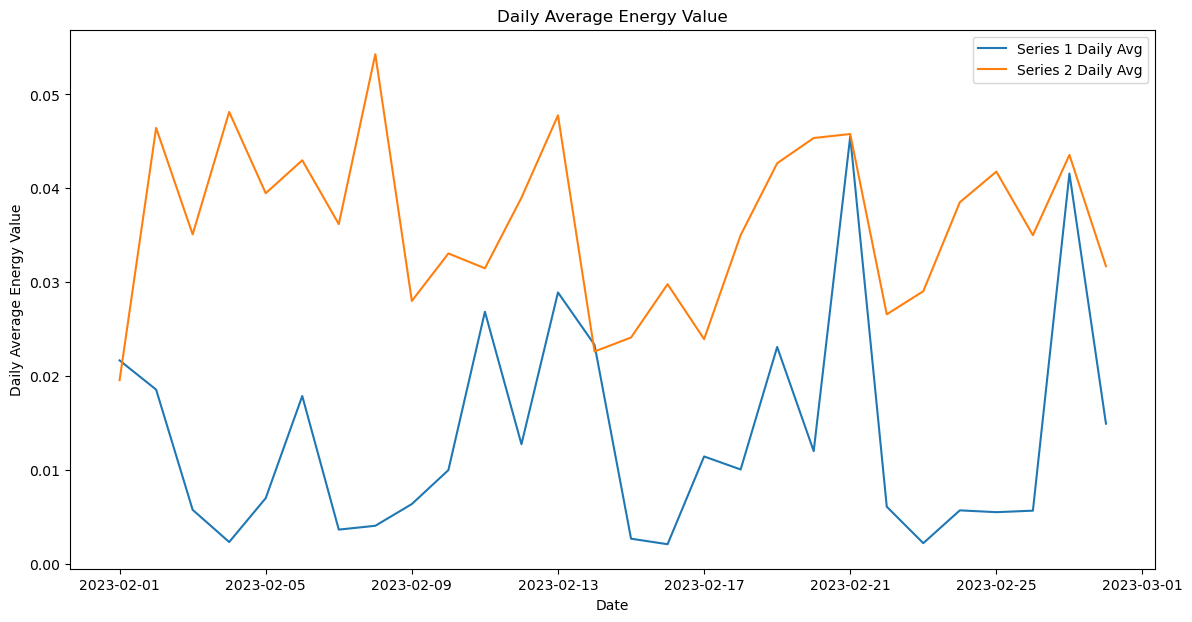

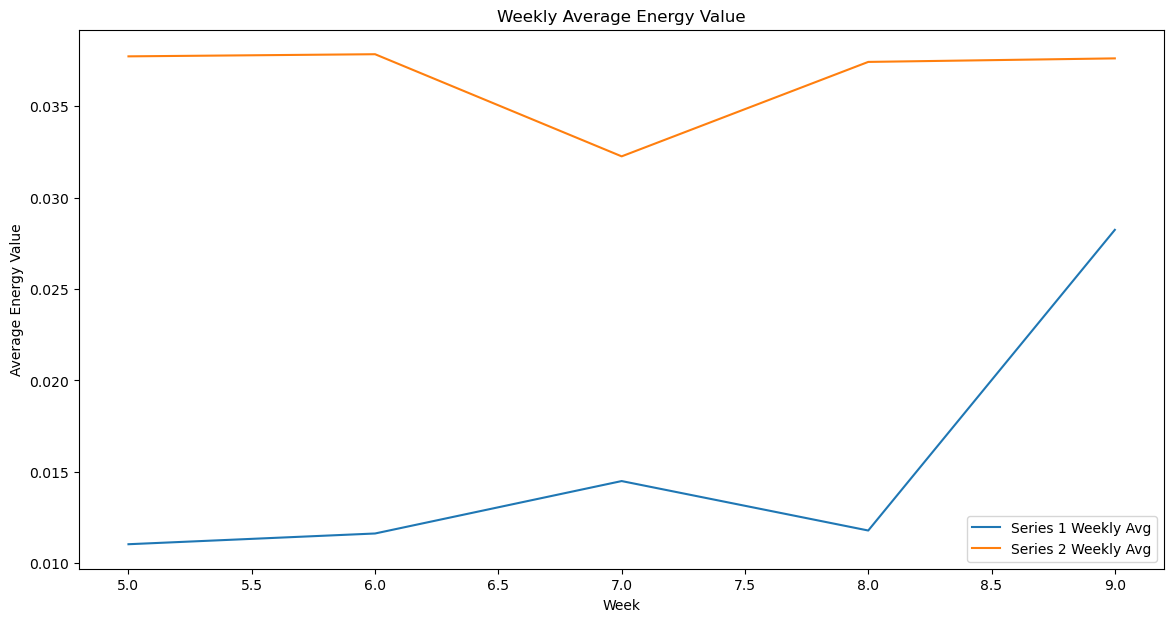

In [16]:
def daily_and_weekly_aggregation(df, value_col):
    df['date'] = df['timestamp'].dt.date
    daily_avg = df.groupby('date')[value_col].mean()

    df['week'] = df['timestamp'].dt.isocalendar().week
    weekly_avg = df.groupby('week')[value_col].mean()
    return daily_avg, weekly_avg

daily_avg1, weekly_avg1 = daily_and_weekly_aggregation(df1, '0100021D00FF')
daily_avg2, weekly_avg2 = daily_and_weekly_aggregation(df2, '0100011D00FF')

# Plotting daily and weekly averages
plt.figure(figsize=(14, 7))
plt.plot(daily_avg1.index, daily_avg1.values, label='Series 1 Daily Avg')
plt.plot(daily_avg2.index, daily_avg2.values, label='Series 2 Daily Avg')
plt.title('Daily Average Energy Value')
plt.xlabel('Date')
plt.ylabel('Daily Average Energy Value')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(weekly_avg1.index, weekly_avg1.values, label='Series 1 Weekly Avg')
plt.plot(weekly_avg2.index, weekly_avg2.values, label='Series 2 Weekly Avg')
plt.title('Weekly Average Energy Value')
plt.xlabel('Week')
plt.ylabel('Average Energy Value')
plt.legend()
plt.show()


### Autocorrelation 

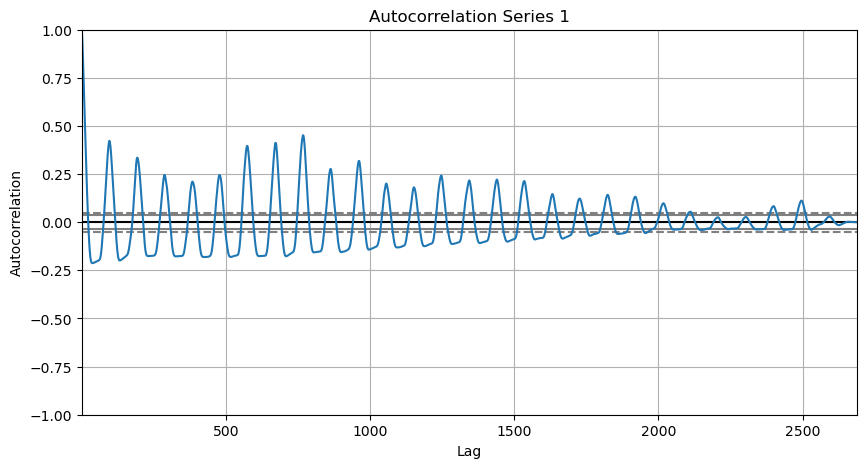

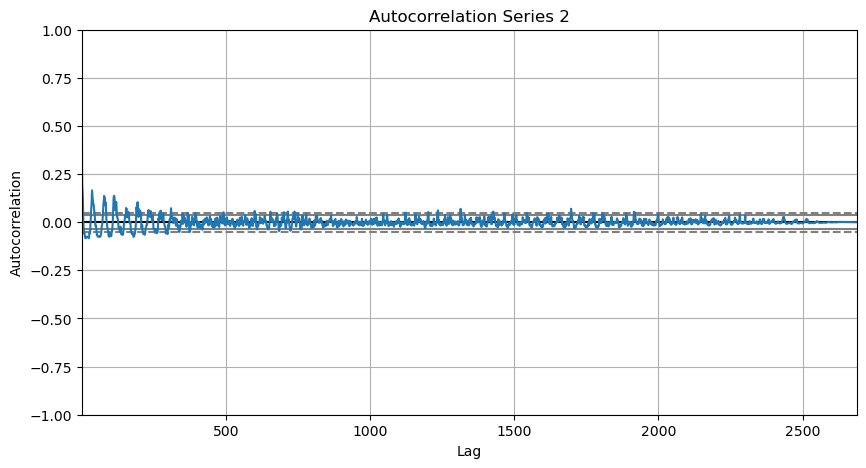

In [17]:
from pandas.plotting import autocorrelation_plot

# Autocorrelation for Series 1
plt.figure(figsize=(10, 5))
autocorrelation_plot(df1['0100021D00FF'])
plt.title('Autocorrelation Series 1')
plt.show()

# Autocorrelation for Series 2
plt.figure(figsize=(10, 5))
autocorrelation_plot(df2['0100011D00FF'])
plt.title('Autocorrelation Series 2')
plt.show()


### Seasonal Decomposition

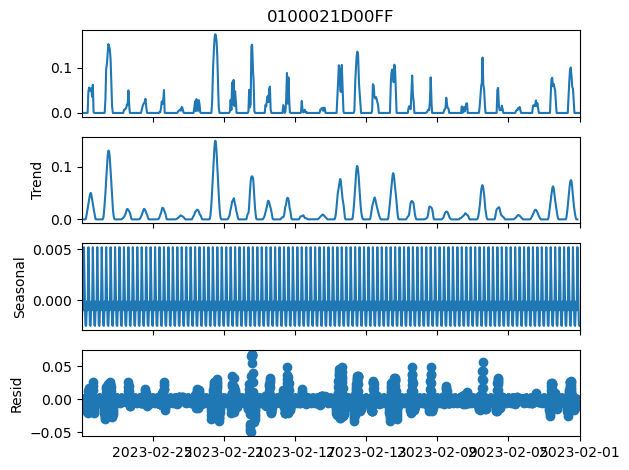

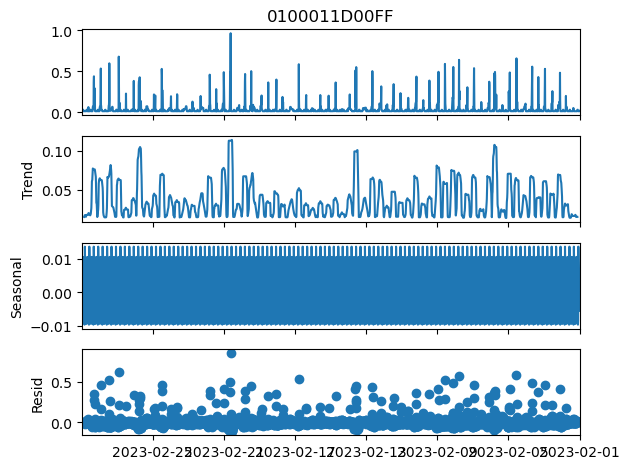

In [18]:
# Decompose Series 1
decomposition1 = seasonal_decompose(df1.set_index('timestamp')['0100021D00FF'], model='additive', period=24)
decomposition1.plot()
plt.show()

# Decompose Series 2
decomposition2 = seasonal_decompose(df2.set_index('timestamp')['0100011D00FF'], model='additive', period=24)
decomposition2.plot()
plt.show()


### Anomaly/Outlier Detection (using z-score)

In [19]:
from scipy.stats import zscore

# Compute z-scores for residuals
df1['residual_zscore'] = zscore(decomposition1.resid)
df2['residual_zscore'] = zscore(decomposition2.resid)

# Identify anomalies (e.g., z-score > 3 or < -3)
anomalies1 = df1[df1['residual_zscore'].abs() > 3]
anomalies2 = df2[df2['residual_zscore'].abs() > 3]

print("Anomalies in Series 1:\n", anomalies1)
print("Anomalies in Series 2:\n", anomalies2)

Anomalies in Series 1:
 Empty DataFrame
Columns: [measurement, timestamp, 0100021D00FF, tags.muid, tags.quality, hour, minute, day_of_week, weekday, date, week, residual_zscore]
Index: []
Anomalies in Series 2:
 Empty DataFrame
Columns: [measurement, timestamp, 0100011D00FF, tags.muid, tags.quality, hour, minute, day_of_week, weekday, date, week, residual_zscore]
Index: []
